# XGBoost Assignment - House Price Predictions

In [65]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import KFold, cross_val_score, train_test_split
import xgboost as xgb
from sklearn.metrics import mean_squared_error

In [2]:
train_data = pd.read_csv('train.csv')
test_data = pd.read_csv('test.csv')

In [3]:
train_data.head(5)

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,...,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
0,1,60,RL,65.0,8450,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,2,2008,WD,Normal,208500
1,2,20,RL,80.0,9600,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,5,2007,WD,Normal,181500
2,3,60,RL,68.0,11250,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,9,2008,WD,Normal,223500
3,4,70,RL,60.0,9550,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,2,2006,WD,Abnorml,140000
4,5,60,RL,84.0,14260,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,12,2008,WD,Normal,250000


In [4]:
test_data.head(5)

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,...,ScreenPorch,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition
0,1461,20,RH,80.0,11622,Pave,NaN,Reg,Lvl,AllPub,...,120,0,NaN,MnPrv,NaN,0,6,2010,WD,Normal
1,1462,20,RL,81.0,14267,Pave,NaN,IR1,Lvl,AllPub,...,0,0,NaN,NaN,Gar2,12500,6,2010,WD,Normal
2,1463,60,RL,74.0,13830,Pave,NaN,IR1,Lvl,AllPub,...,0,0,NaN,MnPrv,NaN,0,3,2010,WD,Normal
3,1464,60,RL,78.0,9978,Pave,NaN,IR1,Lvl,AllPub,...,0,0,NaN,NaN,NaN,0,6,2010,WD,Normal
4,1465,120,RL,43.0,5005,Pave,NaN,IR1,HLS,AllPub,...,144,0,NaN,NaN,NaN,0,1,2010,WD,Normal


In [5]:
## Count of top 20 Fields of train data having null values
train_data.isnull().sum().sort_values(ascending=False).iloc[:20]

PoolQC          1453
MiscFeature     1406
Alley           1369
Fence           1179
MasVnrType       872
FireplaceQu      690
LotFrontage      259
GarageYrBlt       81
GarageCond        81
GarageType        81
GarageFinish      81
GarageQual        81
BsmtFinType2      38
BsmtExposure      38
BsmtQual          37
BsmtCond          37
BsmtFinType1      37
MasVnrArea         8
Electrical         1
Id                 0
dtype: int64

In [6]:
## Count of top 35 Fields of test data having null values
test_data.isnull().sum().sort_values(ascending=False).iloc[:35]

PoolQC          1456
MiscFeature     1408
Alley           1352
Fence           1169
MasVnrType       894
FireplaceQu      730
LotFrontage      227
GarageYrBlt       78
GarageQual        78
GarageFinish      78
GarageCond        78
GarageType        76
BsmtCond          45
BsmtQual          44
BsmtExposure      44
BsmtFinType1      42
BsmtFinType2      42
MasVnrArea        15
MSZoning           4
BsmtHalfBath       2
Utilities          2
Functional         2
BsmtFullBath       2
BsmtFinSF1         1
BsmtFinSF2         1
BsmtUnfSF          1
KitchenQual        1
TotalBsmtSF        1
Exterior2nd        1
GarageCars         1
Exterior1st        1
GarageArea         1
SaleType           1
MiscVal            0
BedroomAbvGr       0
dtype: int64

In [7]:
train_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1460 entries, 0 to 1459
Data columns (total 81 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   Id             1460 non-null   int64  
 1   MSSubClass     1460 non-null   int64  
 2   MSZoning       1460 non-null   object 
 3   LotFrontage    1201 non-null   float64
 4   LotArea        1460 non-null   int64  
 5   Street         1460 non-null   object 
 6   Alley          91 non-null     object 
 7   LotShape       1460 non-null   object 
 8   LandContour    1460 non-null   object 
 9   Utilities      1460 non-null   object 
 10  LotConfig      1460 non-null   object 
 11  LandSlope      1460 non-null   object 
 12  Neighborhood   1460 non-null   object 
 13  Condition1     1460 non-null   object 
 14  Condition2     1460 non-null   object 
 15  BldgType       1460 non-null   object 
 16  HouseStyle     1460 non-null   object 
 17  OverallQual    1460 non-null   int64  
 18  OverallC

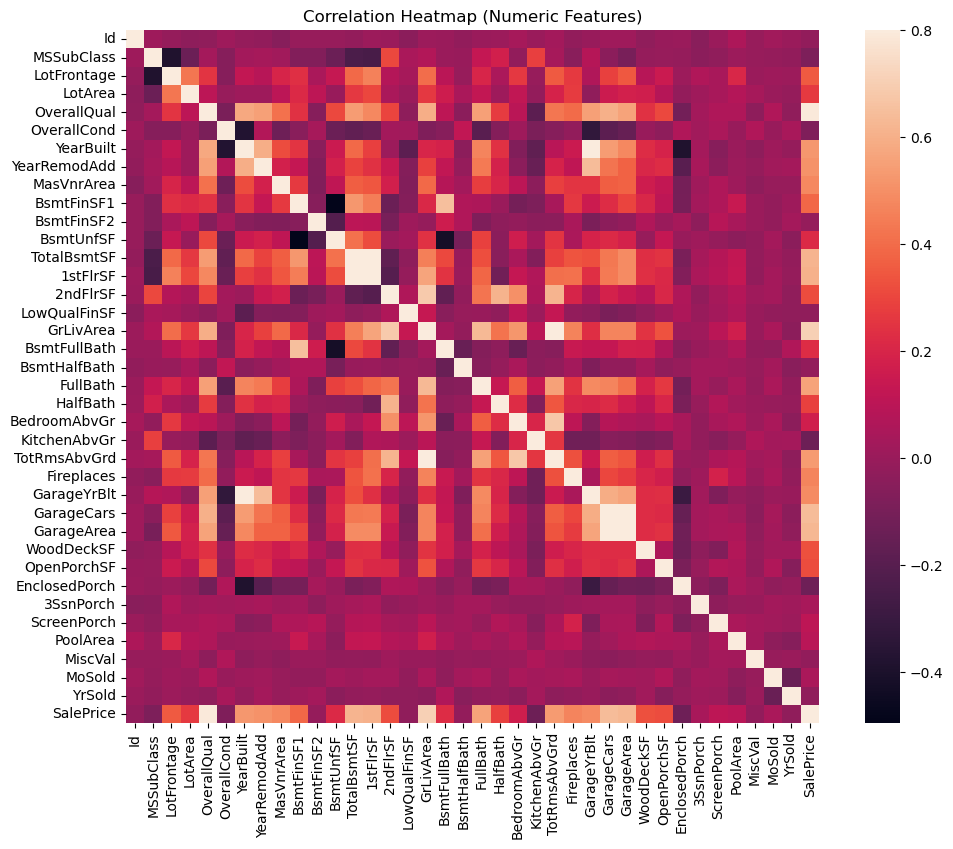

In [8]:
# Filter numeric columns (excluding object columns)
numeric_columns = train_data.select_dtypes(include=['float64', 'int64'])

# Calculate the correlation matrix
correlation_matrix = numeric_columns.corr()

# Create a heatmap to visualize the correlations
plt.figure(figsize=(12, 9))
sns.heatmap(correlation_matrix, vmax=.8,square=True)
plt.title('Correlation Heatmap (Numeric Features)')
plt.show()

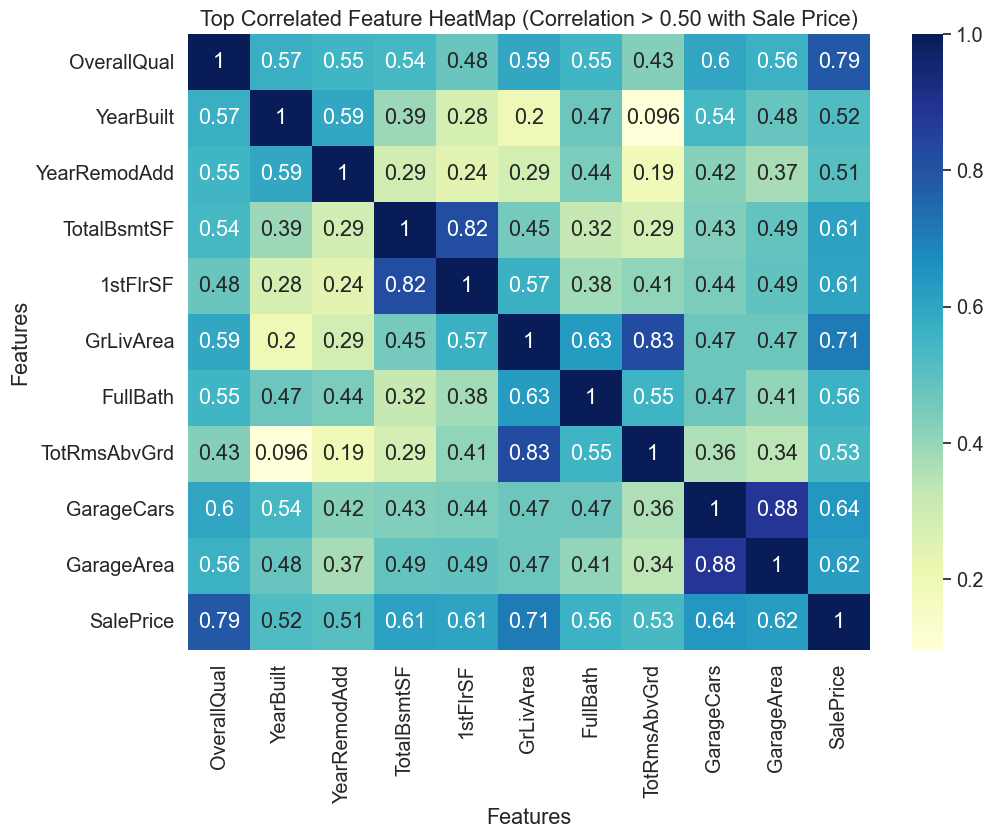

In [9]:
# Correlation matrix
correlation_matrix = numeric_columns.corr()

# Set the threshold for highly correlated features
threshold = 0.5

# Find the features highly correlated with "SalePrice"
highly_correlated_features = correlation_matrix.index[abs(correlation_matrix["SalePrice"]) > threshold]

# Create a heatmap for the top correlated features
plt.figure(figsize=(11, 8))
sns.set(font_scale=1.3)
sns.heatmap(train_data[highly_correlated_features].corr(), annot=True, cmap="YlGnBu")
plt.title("Top Correlated Feature HeatMap (Correlation > {:.2f} with Sale Price)".format(threshold))
plt.xlabel("Features")
plt.ylabel("Features")
plt.show()

In [10]:
# Calculate the correlation values with SalePrice but exclude SalePrice
correlation_values = numeric_columns.corr()['SalePrice'].drop('SalePrice')

# Sort the correlation values in descending order
correlation_values_sorted = correlation_values.sort_values(ascending=False)

print("Correlation Values with SalePrice (Numeric Columns Only):")
print(correlation_values_sorted)

Correlation Values with SalePrice (Numeric Columns Only):
OverallQual      0.790982
GrLivArea        0.708624
GarageCars       0.640409
GarageArea       0.623431
TotalBsmtSF      0.613581
1stFlrSF         0.605852
FullBath         0.560664
TotRmsAbvGrd     0.533723
YearBuilt        0.522897
YearRemodAdd     0.507101
GarageYrBlt      0.486362
MasVnrArea       0.477493
Fireplaces       0.466929
BsmtFinSF1       0.386420
LotFrontage      0.351799
WoodDeckSF       0.324413
2ndFlrSF         0.319334
OpenPorchSF      0.315856
HalfBath         0.284108
LotArea          0.263843
BsmtFullBath     0.227122
BsmtUnfSF        0.214479
BedroomAbvGr     0.168213
ScreenPorch      0.111447
PoolArea         0.092404
MoSold           0.046432
3SsnPorch        0.044584
BsmtFinSF2      -0.011378
BsmtHalfBath    -0.016844
MiscVal         -0.021190
Id              -0.021917
LowQualFinSF    -0.025606
YrSold          -0.028923
OverallCond     -0.077856
MSSubClass      -0.084284
EnclosedPorch   -0.128578
Kitche

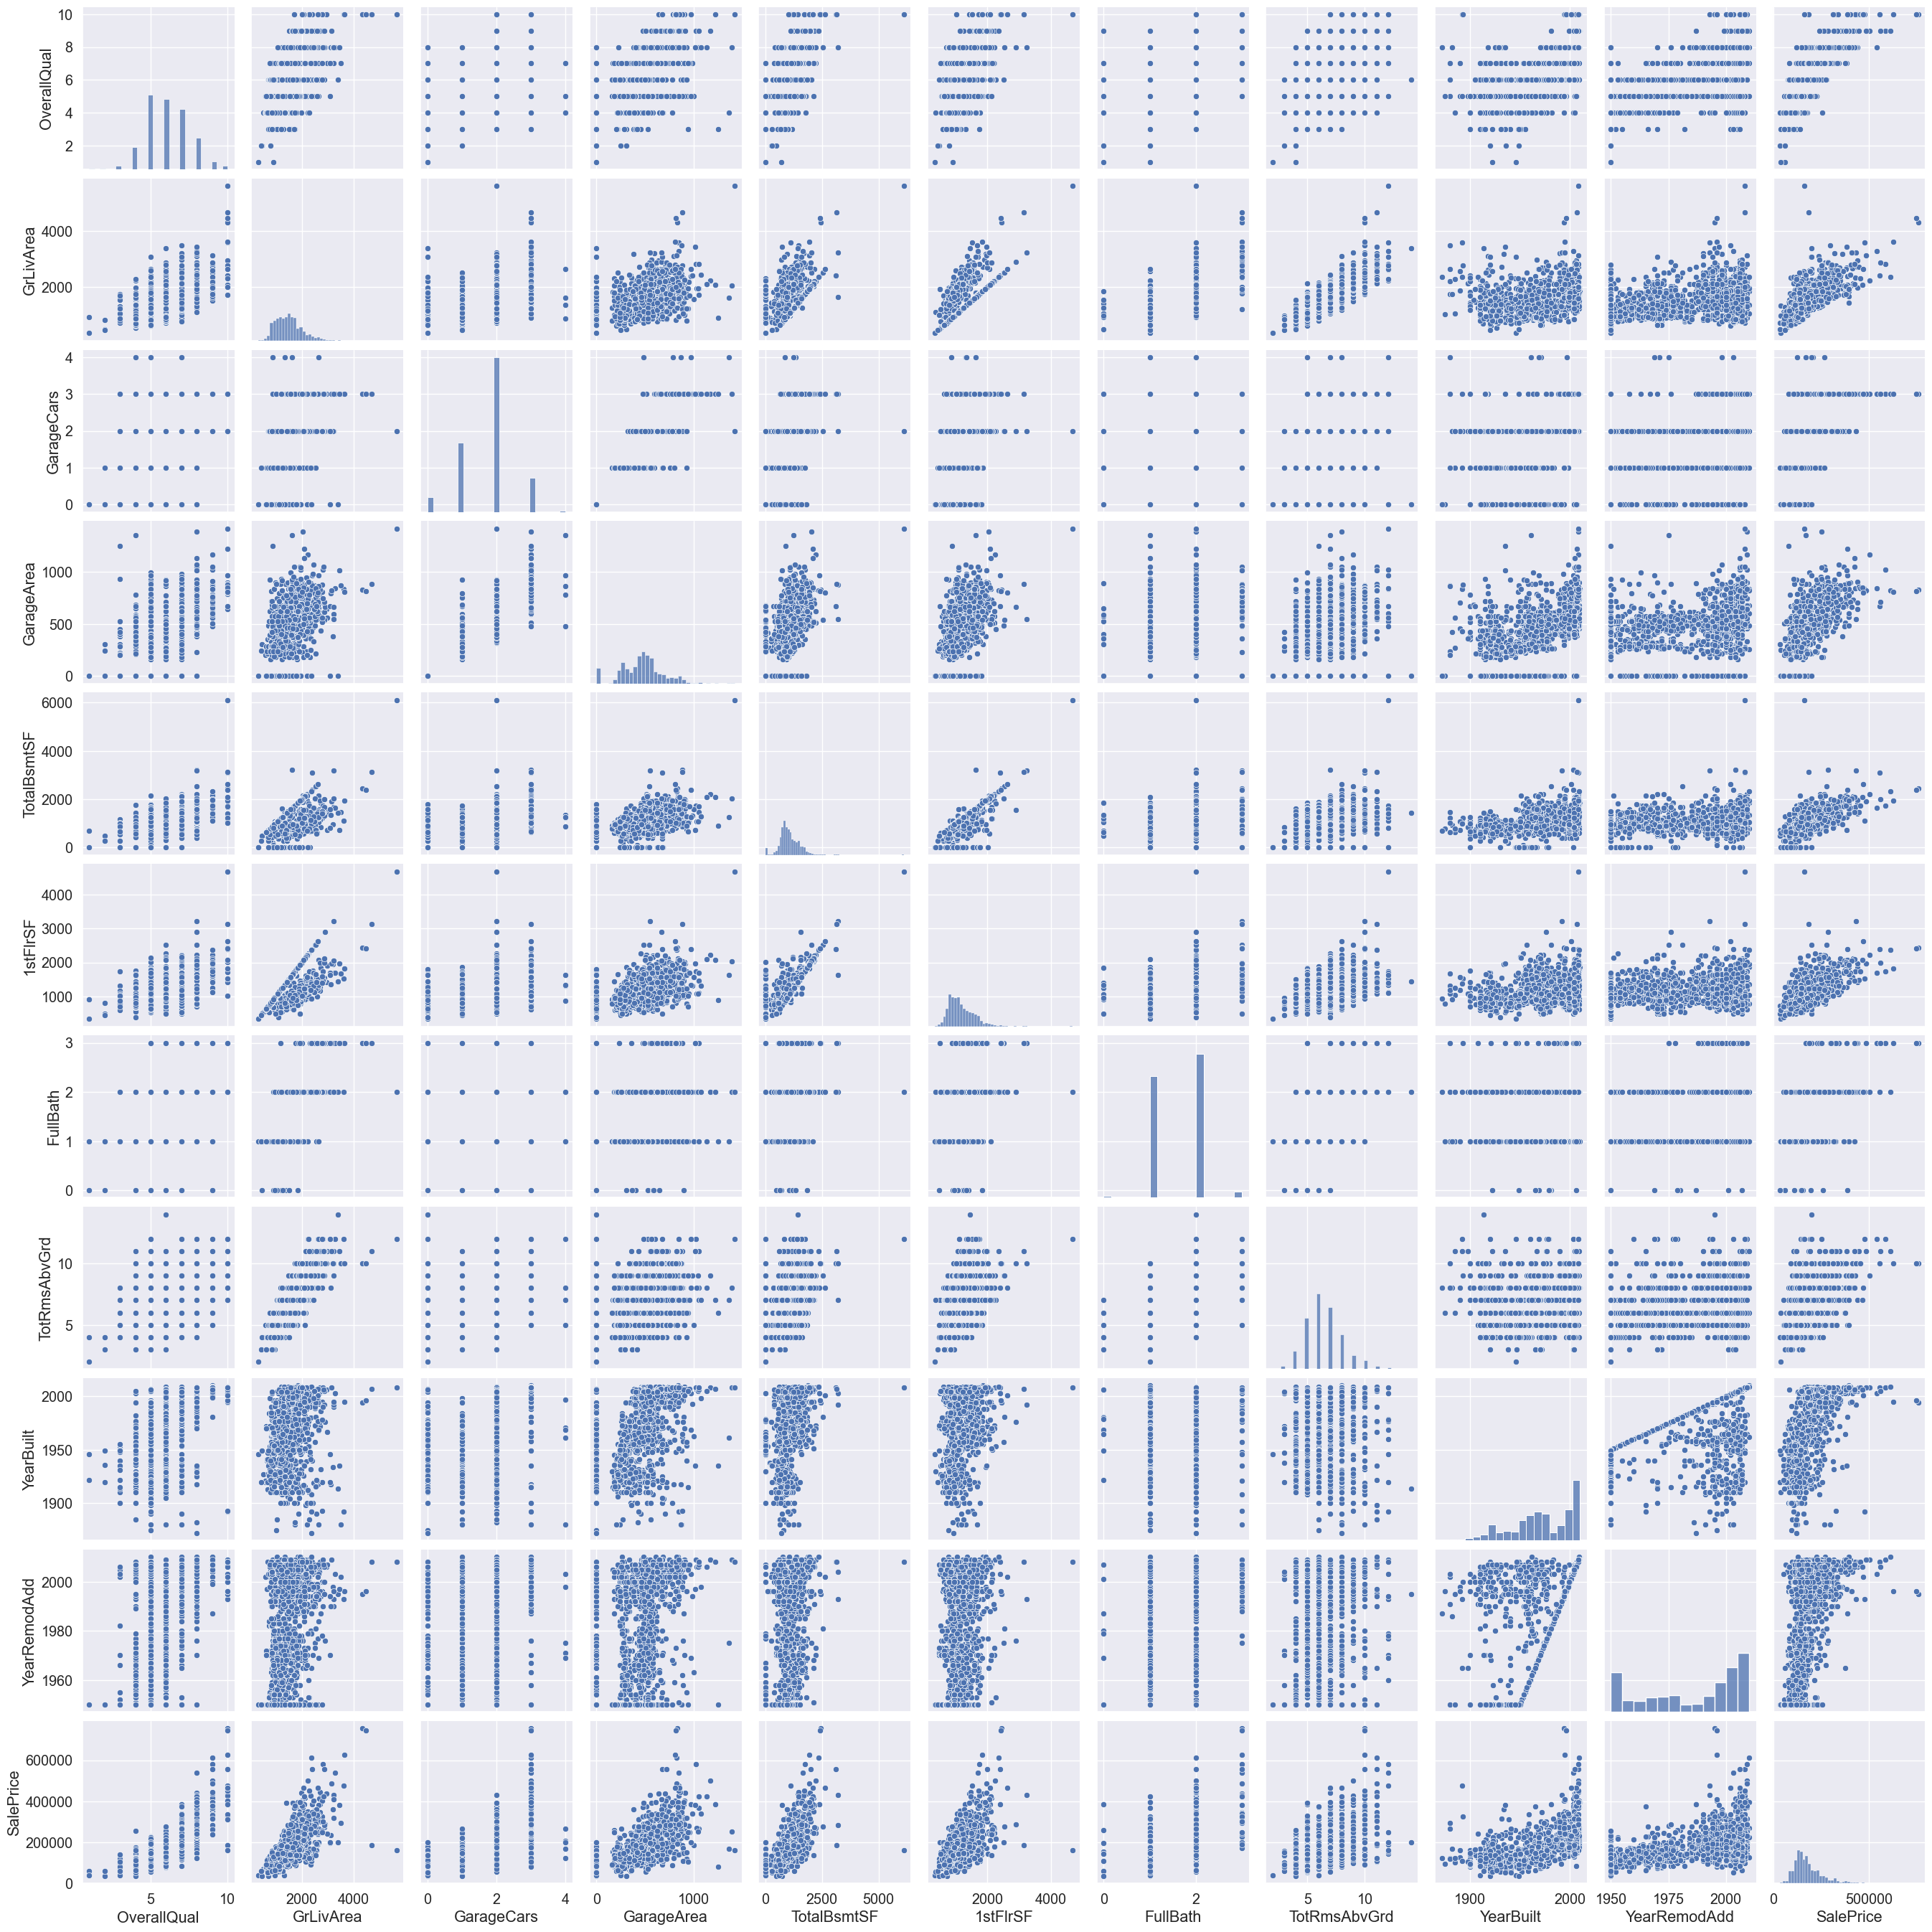

<Figure size 500x500 with 0 Axes>

In [11]:
# Select the top 10 most correlated features (including SalePrice)
top_10_features = correlation_values.nlargest(10).index.tolist()
top_10_features.append('SalePrice')  # Include SalePrice in the list

# Create scatter plots for the top 10 most correlated features
sns_plot = sns.pairplot(train_data[top_10_features])

# Set the figure size
plt.figure(figsize=(5, 5))

# Set the title and adjust layout
plt.suptitle('Scatter plots between top 10 most correlated features', y=1.04, size=25)
plt.tight_layout()

# Show the scatter plots
plt.show()

In [12]:
# copy test/train DF

train_data_2 = train_data.copy()
test_data_2 = test_data.copy()


In [13]:
# As'Id' is present in both train_data and test_data...

# 'Id' columns in separate variables
train_ID = train_data['Id']
test_ID = test_data['Id']

# Drop 'Id' columns from train_data and test_data
train_data.drop(['Id'], axis=1, inplace=True)
test_data.drop(['Id'], axis=1, inplace=True)

# Check the updated shapes of train_data and test_data
print("Updated shapes - train_data: {}, test_data: {}".format(train_data.shape, test_data.shape))

Updated shapes - train_data: (1460, 80), test_data: (1459, 79)


In [14]:
# Set seaborn style and edgecolor
sns.set_style('whitegrid')
edgecolor = 'black'

# Function to plot scatter plot between a feature and the Sale Price
def scatter_plot(data, feature_name, target_name):
    fig, ax = plt.subplots()
    ax.scatter(x=data[feature_name], y=data[target_name], edgecolor=edgecolor)
    plt.ylabel(target_name, fontsize=12)
    plt.xlabel(feature_name, fontsize=12)
    plt.suptitle("Scatter Plot of " + feature_name + " and " + target_name)
    plt.show()

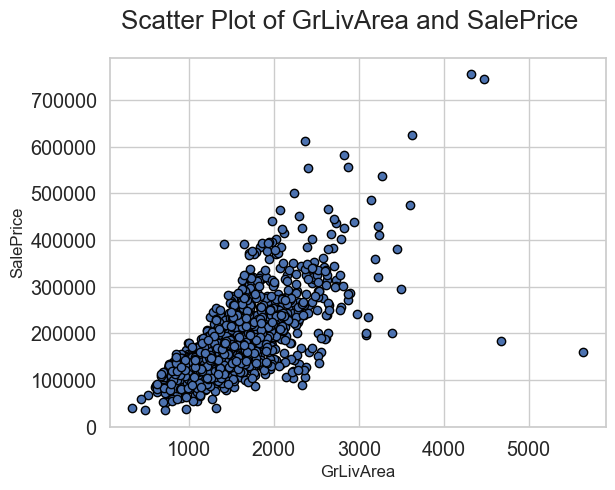

In [15]:
# Plot GrLivArea + SalePrice
scatter_plot(train_data, 'GrLivArea', 'SalePrice')

In [16]:
# Deleting outliers

# Define the conditions for outliers
condition = (train_data['GrLivArea'] > 4000) & (train_data['SalePrice'] < 300000)

# Drop the rows that meet the outlier conditions
train_data = train_data.drop(train_data[condition].index)

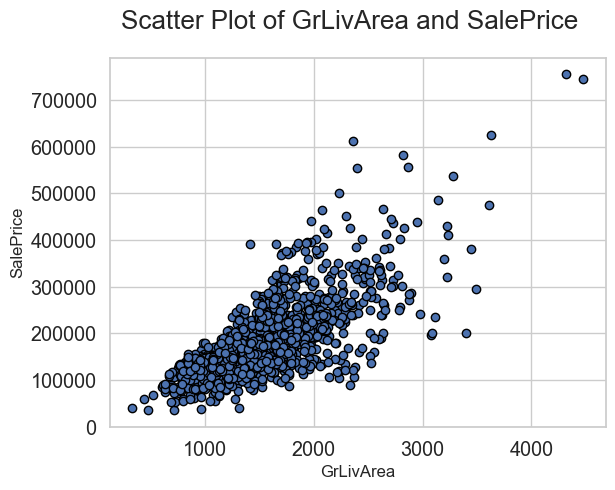

In [17]:
# Plot GrLivArea + SalePrice
scatter_plot(train_data, 'GrLivArea', 'SalePrice')

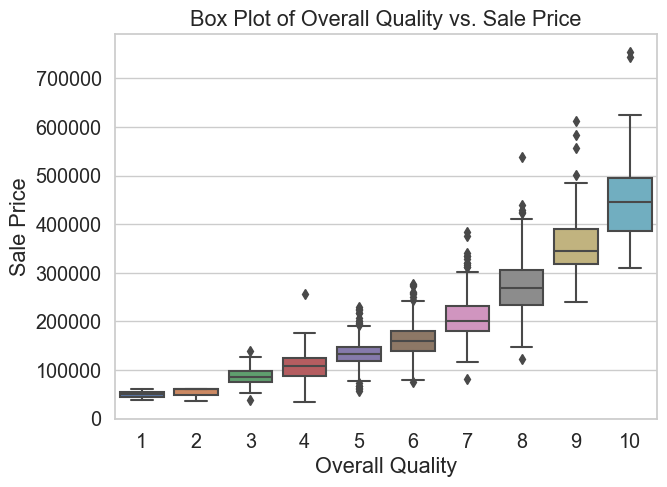

In [18]:
# Set the figure size
plt.figure(figsize=(7,5))

# Create a box plot for 'OverallQual' vs. 'SalePrice'
sns.boxplot(x='OverallQual', y='SalePrice', data=train_data)

# Set labels and title
plt.xlabel('Overall Quality')
plt.ylabel('Sale Price')
plt.title('Box Plot of Overall Quality vs. Sale Price')

# Show the plot
plt.show()

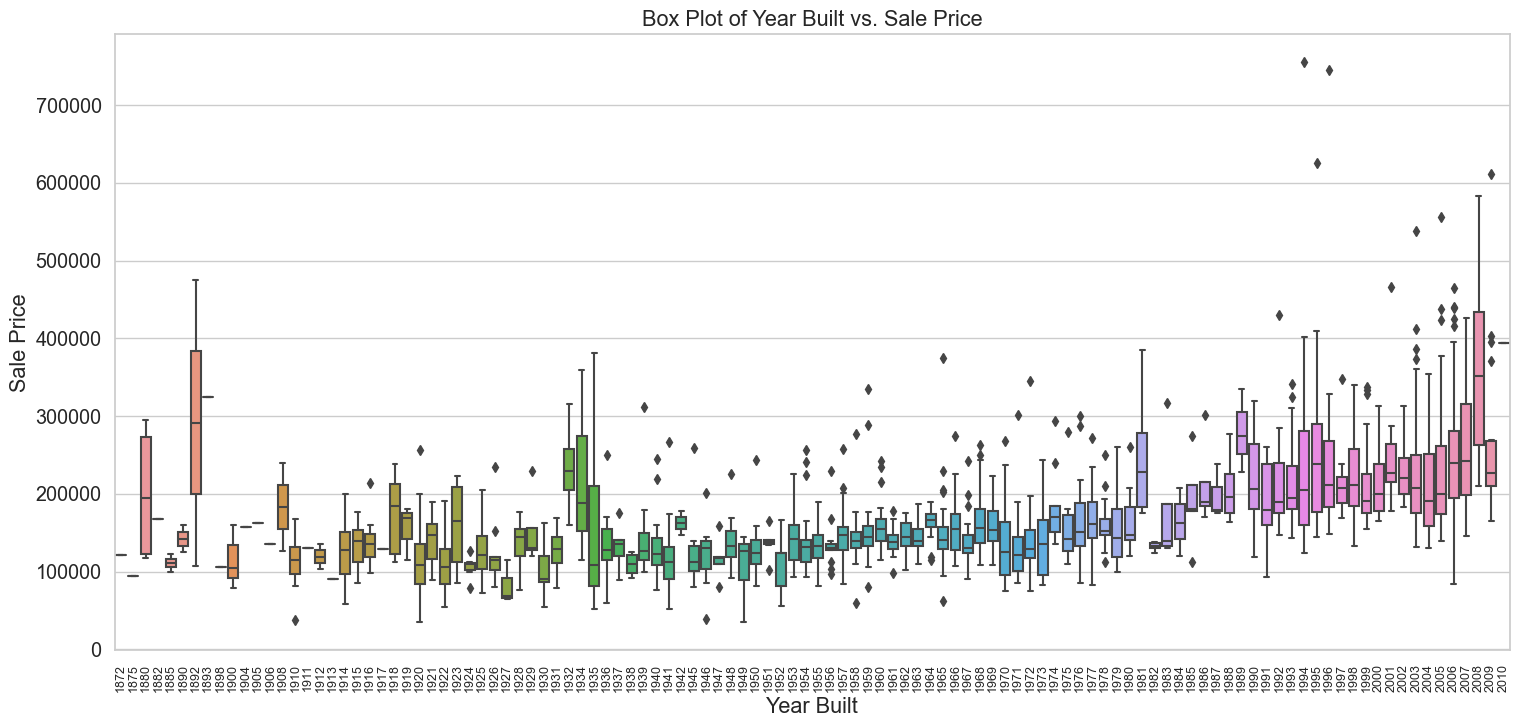

In [19]:
# Set the figure size
plt.figure(figsize=(18, 8))

# Create a box plot for 'YearBuilt' vs. 'SalePrice'
sns.boxplot(x='YearBuilt', y='SalePrice', data=train_data)
plt.xticks(rotation=90, fontsize=9)

# Set labels and title
plt.xlabel('Year Built')
plt.ylabel('Sale Price')
plt.title('Box Plot of Year Built vs. Sale Price')

# Show the plot
plt.show()

C:\Users\Curtis\AppData\Local\Temp\ipykernel_2516\2385222260.py:2: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(train_data['SalePrice'])


Skewness: 1.881296
Kurtosis: 6.523067


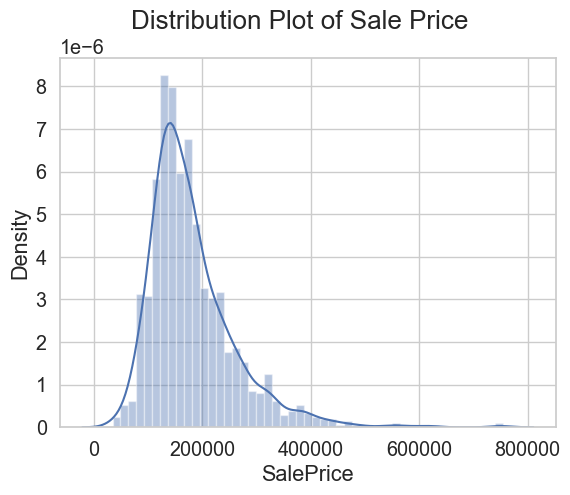

In [20]:
# Create a distribution plot for 'SalePrice' using histplot
sns.distplot(train_data['SalePrice'])

# Set the plot title
plt.suptitle("Distribution Plot of Sale Price")

# Calculate and print skewness and kurtosis
skewness = train_data['SalePrice'].skew()
kurtosis = train_data['SalePrice'].kurt()
print("Skewness: %f" % skewness)
print("Kurtosis: %f" % kurtosis)

# Show the plot
plt.show()

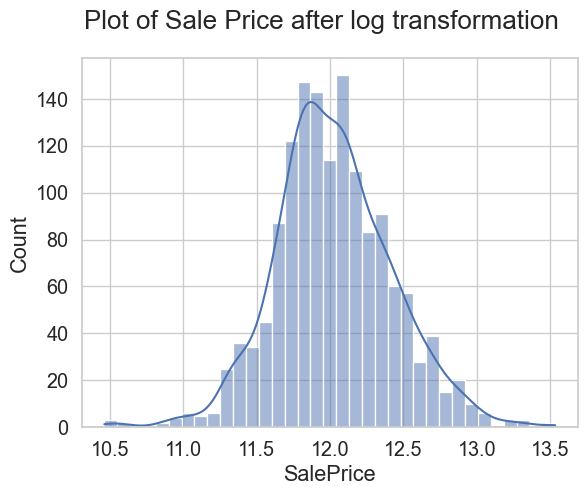

In [21]:
# Apply log transformation to 'SalePrice'
train_data['SalePrice'] = np.log(train_data['SalePrice'])

# Set the plot title
plt.suptitle("Plot of Sale Price after log transformation")

# Create a distribution plot for the transformed 'SalePrice'
sns.histplot(train_data['SalePrice'], kde=True)

# Show the plot
plt.show()

In [22]:
train_data.shape

(1458, 80)

## Handle Missing Values

In [23]:
#function to see the missing data in a dataframe
def missing_data(df,n):    
    total = df.isnull().sum().sort_values(ascending=False)          # Total No of missing values
    percentage = (df.isnull().sum() / df.isnull().count()).sort_values(ascending=False)*100  # % of Missing values
    No_unique_val = df.nunique()                                   # No of unique values
    missing_data = pd.concat([total, percentage, No_unique_val], axis=1, 
                             keys=['Total No of missing val', '% of Missing val','No of unique val'], sort = False)
    
    print(missing_data.head(n))

In [24]:
#training data    
missing_data(train_data,20)

              Total No of missing val  % of Missing val  No of unique val
PoolQC                           1452         99.588477                 3
MiscFeature                      1404         96.296296                 4
Alley                            1367         93.758573                 2
Fence                            1177         80.727023                 4
MasVnrType                        872         59.807956                 3
FireplaceQu                       690         47.325103                 5
LotFrontage                       259         17.764060               110
GarageYrBlt                        81          5.555556                97
GarageCond                         81          5.555556                 5
GarageType                         81          5.555556                 6
GarageFinish                       81          5.555556                 3
GarageQual                         81          5.555556                 5
BsmtExposure                       38 

In [25]:
train_data['PoolQC'].unique()

array([nan, 'Ex', 'Fa', 'Gd'], dtype=object)

In [26]:
#test data 
missing_data(test_data,34)

              Total No of missing val  % of Missing val  No of unique val
PoolQC                           1456         99.794380                 2
MiscFeature                      1408         96.504455                 3
Alley                            1352         92.666210                 2
Fence                            1169         80.123372                 4
MasVnrType                        894         61.274846                 3
FireplaceQu                       730         50.034270                 5
LotFrontage                       227         15.558602               115
GarageYrBlt                        78          5.346127                97
GarageFinish                       78          5.346127                 3
GarageQual                         78          5.346127                 4
GarageCond                         78          5.346127                 5
GarageType                         76          5.209047                 6
BsmtCond                           45 

In [27]:
test_data['Utilities'].unique()

array(['AllPub', nan], dtype=object)

In [28]:
# calculate total number of null values in training data
null_train = train_data.isnull().sum().sum()
print(null_train)

# calculate total number of null values in test data
null_test = test_data.isnull().sum().sum()
print(null_test)

7822
7878


In [29]:
# save the 'SalePrice'column as train_label
train_label = train_data['SalePrice'].reset_index(drop=True)

# # drop 'SalePrice' column from df_train 
train_data = train_data.drop(['SalePrice'], axis=1)
# # now df_train contains all training features

In [30]:
# function to HANDLE the missing data in a dataframe
def missing (df):
    
    # drop theses columns due to large null values or many same values
    df = df.drop(['Utilities','PoolQC','MiscFeature','Alley'], axis=1)
    
    # Null value likely means No Fence so fill as "None"
    df["Fence"] = df["Fence"].fillna("None") 
    
    # Null value likely means No Fireplace so fill as "None"
    df["FireplaceQu"] = df["FireplaceQu"].fillna("None")
    
    # Lot frontage is the feet of street connected to property, which is likely similar to the neighbourhood houses, so fill Median value
    df["LotFrontage"] = df["LotFrontage"].fillna(df["LotFrontage"].median())
    
    # Null value likely means  typical(Typ)
    df["Functional"] = df["Functional"].fillna("Typ")
    
    # Only one null value so fill as the most frequent value(mode)
    df['KitchenQual'] = df['KitchenQual'].fillna(df['KitchenQual'].mode()[0])  
    
    # Only one null value so fill as the most frequent value(mode)
    df['Electrical'] = df['Electrical'].fillna(df['Electrical'].mode()[0])
    
    # Very few null value so fill with the most frequent value(mode)
    df['SaleType'] = df['SaleType'].fillna(df['SaleType'].mode()[0])
    
    # Null value likely means no masonry veneer
    df["MasVnrType"] = df["MasVnrType"].fillna("None") #so fill as "None" (since categorical feature)
    df["MasVnrArea"] = df["MasVnrArea"].fillna(0)      #so fill as o
    
    # Only one null value so fill as the most frequent value(mode)
    df['Exterior1st'] = df['Exterior1st'].fillna(df['Exterior1st'].mode()[0])
    df['Exterior2nd'] = df['Exterior2nd'].fillna(df['Exterior2nd'].mode()[0])
    
    #MSZoning is general zoning classification,Very few null value so fill with the most frequent value(mode)
    df['MSZoning'] = df['MSZoning'].fillna(df['MSZoning'].mode()[0])
    
    #Null value likely means no Identified type of dwelling so fill as "None"
    df['MSSubClass'] = df['MSSubClass'].fillna("None")
    
    # Null value likely means No Garage, so fill as "None" (since these are categorical features)
    for col in ('GarageType', 'GarageFinish', 'GarageQual', 'GarageCond'):
        df[col] = df[col].fillna('None')
    
    # Null value likely means No Garage and no cars in garage, so fill as 0
    for col in ('GarageYrBlt', 'GarageArea', 'GarageCars'):
        df[col] = df[col].fillna(0)
    
    # Null value likely means No Basement, so fill as 0
    for col in ('BsmtFinSF1', 'BsmtFinSF2', 'BsmtUnfSF','TotalBsmtSF', 'BsmtFullBath', 'BsmtHalfBath'):
        df[col] = df[col].fillna(0)
    
    # Null value likely means No Basement, so fill as "None" (since these are categorical features)
    for col in ('BsmtQual', 'BsmtCond', 'BsmtExposure', 'BsmtFinType1', 'BsmtFinType2'):
        df[col] = df[col].fillna('None')
    
    return df

In [31]:
train_data = missing(train_data)
test_data = missing(test_data)

In [32]:
# calculate total number of null values in training data
null_train = train_data.isnull().sum().sum()
print(null_train)

# calculate total number of null values in test data
null_test = test_data.isnull().sum().sum()
print(null_test)

0
0


In [33]:
train_data.shape,test_data.shape

((1458, 75), (1459, 75))

#### Feature Engineering

In [34]:
def add_new_cols(df):
    
    df['Total_SF'] = df['TotalBsmtSF'] + df['1stFlrSF'] + df['2ndFlrSF']

    df['Total_Bathrooms'] = (df['FullBath'] + (0.5 * df['HalfBath']) + df['BsmtFullBath'] 
                             + (0.5 * df['BsmtHalfBath']))

    df['Total_Porch_SF'] = (df['OpenPorchSF'] + df['3SsnPorch'] + df['EnclosedPorch'] + 
                            df['ScreenPorch'] + df['WoodDeckSF'])

    df['Total_Square_Feet'] = (df['BsmtFinSF1'] + df['BsmtFinSF2'] + df['1stFlrSF'] + df['2ndFlrSF'])
    
    df['Total_Quality'] = df['OverallQual'] + df['OverallCond']
    
    return df

In [35]:
# add the new columns
train_data = add_new_cols(train_data)
test_data = add_new_cols(test_data)

In [36]:
train_data.shape,test_data.shape

((1458, 80), (1459, 80))

#### Data Types

In [37]:
#training data
g1 = train_data.columns.to_series().groupby(train_data.dtypes).groups

In [38]:
{k.name: v for k, v in g1.items()}

{'int64': Index(['MSSubClass', 'LotArea', 'OverallQual', 'OverallCond', 'YearBuilt',
        'YearRemodAdd', 'BsmtFinSF1', 'BsmtFinSF2', 'BsmtUnfSF', 'TotalBsmtSF',
        '1stFlrSF', '2ndFlrSF', 'LowQualFinSF', 'GrLivArea', 'BsmtFullBath',
        'BsmtHalfBath', 'FullBath', 'HalfBath', 'BedroomAbvGr', 'KitchenAbvGr',
        'TotRmsAbvGrd', 'Fireplaces', 'GarageCars', 'GarageArea', 'WoodDeckSF',
        'OpenPorchSF', 'EnclosedPorch', '3SsnPorch', 'ScreenPorch', 'PoolArea',
        'MiscVal', 'MoSold', 'YrSold', 'Total_SF', 'Total_Porch_SF',
        'Total_Square_Feet', 'Total_Quality'],
       dtype='object'),
 'float64': Index(['LotFrontage', 'MasVnrArea', 'GarageYrBlt', 'Total_Bathrooms'], dtype='object'),
 'object': Index(['MSZoning', 'Street', 'LotShape', 'LandContour', 'LotConfig',
        'LandSlope', 'Neighborhood', 'Condition1', 'Condition2', 'BldgType',
        'HouseStyle', 'RoofStyle', 'RoofMatl', 'Exterior1st', 'Exterior2nd',
        'MasVnrType', 'ExterQual', 'ExterCon

In [39]:
#testing data
g2 = test_data.columns.to_series().groupby(test_data.dtypes).groups

In [40]:
{k.name: v for k, v in g2.items()}

{'int64': Index(['MSSubClass', 'LotArea', 'OverallQual', 'OverallCond', 'YearBuilt',
        'YearRemodAdd', '1stFlrSF', '2ndFlrSF', 'LowQualFinSF', 'GrLivArea',
        'FullBath', 'HalfBath', 'BedroomAbvGr', 'KitchenAbvGr', 'TotRmsAbvGrd',
        'Fireplaces', 'WoodDeckSF', 'OpenPorchSF', 'EnclosedPorch', '3SsnPorch',
        'ScreenPorch', 'PoolArea', 'MiscVal', 'MoSold', 'YrSold',
        'Total_Porch_SF', 'Total_Quality'],
       dtype='object'),
 'float64': Index(['LotFrontage', 'MasVnrArea', 'BsmtFinSF1', 'BsmtFinSF2', 'BsmtUnfSF',
        'TotalBsmtSF', 'BsmtFullBath', 'BsmtHalfBath', 'GarageYrBlt',
        'GarageCars', 'GarageArea', 'Total_SF', 'Total_Bathrooms',
        'Total_Square_Feet'],
       dtype='object'),
 'object': Index(['MSZoning', 'Street', 'LotShape', 'LandContour', 'LotConfig',
        'LandSlope', 'Neighborhood', 'Condition1', 'Condition2', 'BldgType',
        'HouseStyle', 'RoofStyle', 'RoofMatl', 'Exterior1st', 'Exterior2nd',
        'MasVnrType', 'ExterQ

In [41]:
#get dummy values for categorical data
train_data = pd.get_dummies(train_data)
test_data = pd.get_dummies(test_data)

print(train_data.shape)
print(test_data.shape)

(1458, 292)
(1459, 278)


In [42]:
#align the training and testing data
train_data, test_data = train_data.align(test_data, join = 'inner', axis=1)

In [43]:
print(train_data.shape)
print(test_data.shape)

(1458, 278)
(1459, 278)


In [44]:
# calculate total number of null values in training data
null_train = train_data.isnull().sum().sum()
print(null_train)

# calculate total number of null values in test data
null_test = test_data.isnull().sum().sum()
print(null_test)

0
0


In [45]:
X_test = test_data           # testing features

In [46]:
train_data["SalePrice"] = train_label

In [47]:
train_data.head()

,MSSubClass,LotFrontage,LotArea,OverallQual,OverallCond,YearBuilt,YearRemodAdd,MasVnrArea,BsmtFinSF1,BsmtFinSF2,...,SaleType_New,SaleType_Oth,SaleType_WD,SaleCondition_Abnorml,SaleCondition_AdjLand,SaleCondition_Alloca,SaleCondition_Family,SaleCondition_Normal,SaleCondition_Partial,SalePrice
0,60,65.0,8450,7,5,2003,2003,196.0,706,0,...,False,False,True,False,False,False,False,True,False,12.247694
1,20,80.0,9600,6,8,1976,1976,0.0,978,0,...,False,False,True,False,False,False,False,True,False,12.109011
2,60,68.0,11250,7,5,2001,2002,162.0,486,0,...,False,False,True,False,False,False,False,True,False,12.317167
3,70,60.0,9550,7,5,1915,1970,0.0,216,0,...,False,False,True,True,False,False,False,False,False,11.849398
4,60,84.0,14260,8,5,2000,2000,350.0,655,0,...,False,False,True,False,False,False,False,True,False,12.429216


In [50]:
train_set, valid_set = train_test_split(train_data,train_size= 0.7, shuffle=False)

X_train = train_set.drop(["SalePrice"], axis=1)  # training features
y_train = train_set["SalePrice"].copy()             # training label

X_valid = valid_set.drop(["SalePrice"], axis=1)  # testing features
y_valid = valid_set["SalePrice"].copy()               # testing label

In [51]:
print("X_train shape: {}".format(X_train.shape))
print("y_train shape: {}".format(y_train.shape))
print()
print("X_valid shape: {}".format(X_valid.shape))
print("y_valid shape: {}".format(y_valid.shape))
print()
print("X_test shape: {}".format(X_test.shape))

X_train shape: (1020, 278)
y_train shape: (1020,)

X_valid shape: (438, 278)
y_valid shape: (438,)

X_test shape: (1459, 278)


### Check Data Types and Null Values

In [52]:
X_train.info()

<class 'pandas.core.frame.DataFrame'>
Index: 1020 entries, 0 to 1020
Columns: 278 entries, MSSubClass to SaleCondition_Partial
dtypes: bool(237), float64(4), int64(37)
memory usage: 570.8 KB


In [53]:
X_valid.info()

<class 'pandas.core.frame.DataFrame'>
Index: 438 entries, 1021 to 1459
Columns: 278 entries, MSSubClass to SaleCondition_Partial
dtypes: bool(237), float64(4), int64(37)
memory usage: 245.1 KB


In [54]:
y_train

0       12.247694
1       12.109011
2       12.317167
3       11.849398
4       12.429216
          ...    
1016    12.141534
1017    11.982929
1018    12.271345
1019    12.078239
1020    12.175613
Name: SalePrice, Length: 1020, dtype: float64

In [55]:
y_valid

1021    11.373663
1022    12.160029
1023    12.567237
1024    11.630709
1025    12.028739
          ...    
1455    12.493130
1456    11.864462
1457    11.901583
1458          NaN
1459          NaN
Name: SalePrice, Length: 438, dtype: float64

In [56]:
null_t_x = X_train.isnull().sum().sum()
print(null_t_x)

null_t_y = y_train.isnull().sum().sum()
print(null_t_y)

0
0


In [57]:
null_v_x = X_valid.isnull().sum().sum()
print(null_v_x)

null_v_y = y_valid.isnull().sum().sum()
print(null_v_y)

0
2


In [58]:
np.where(np.isnan(y_valid))

(array([436, 437], dtype=int64),)

In [59]:
# replace null values by mean value of y_valid column
mean = np.nanmean(y_valid)
y_valid = np.nan_to_num(y_valid,nan = mean)

In [60]:
print("Valid data shape:")
print(X_valid.shape, y_valid.shape)
print()

Valid data shape:
(438, 278) (438,)



### Cross Validation

In [61]:
# calculating cross validation score with scoring set to negative mean absolute error
def cross_validation(model):
    
    scores = np.sqrt(-cross_val_score(model, X_train, y_train, cv = 12, scoring = "neg_mean_squared_error"))
    mean = np.mean(scores)
    print("Mean CV score: ",mean)

### RMSE

In [63]:
# function to calculate Root mean square error (RMSE)
def rmse(y_pred, y_train): 
    
    rmse_ = np.sqrt(metrics.mean_squared_error(y_pred,y_train))
    print("rmse: ", rmse_)

In [64]:
# function to plot actual vs predicited label
def actual_vs_pred_plot(y_train,y_pred):
    
    fig = plt.figure(figsize=(12,12))
    fig, ax = plt.subplots()
    
    ax.scatter(y_train, y_pred,color = "teal",edgecolor = 'lightblue')
    ax.plot([y_train.min(),y_train.max()], [y_train.min(), y_train.max()], 'k--',lw=0.2)
    ax.set_xlabel('Actual')
    ax.set_ylabel('Predicted')
    plt.suptitle("Actual vs Predicted Scatter Plot",size=14)
    plt.show()

### XGBoost

In [71]:
import xgboost as xgb
from xgboost import XGBRegressor
from sklearn import metrics

In [72]:
model = XGBRegressor(
    n_estimators=1000,     # Number of boosting rounds
    max_depth=7,           # Maximum depth of a tree
    learning_rate=0.1,     # Learning rate
    subsample=0.7,         # Fraction of samples used for training each tree
    colsample_bytree=0.8   # Fraction of features used for training each tree
)

In [73]:
model.fit(X_train, y_train)

XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=0.8, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=None, gpu_id=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=0.1, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=7, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             n_estimators=1000, n_jobs=None, num_parallel_tree=None,
             predictor=None, random_state=None, ...)

In [74]:
y_pred = model.predict(X_valid)

In [75]:
rmse(y_pred, y_valid)

rmse:  0.4512195322979607


<Figure size 1200x1200 with 0 Axes>

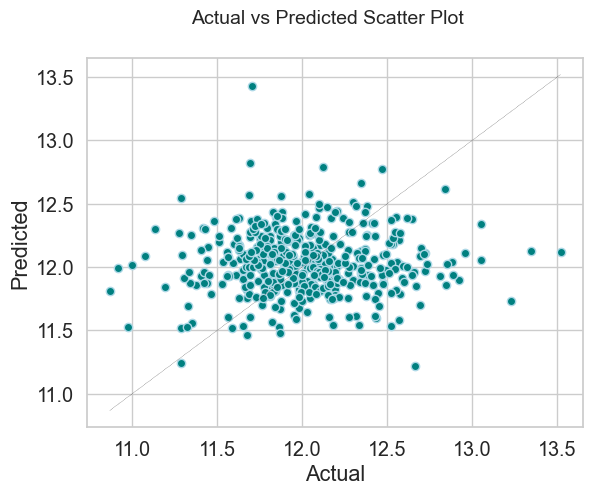

In [76]:
actual_vs_pred_plot(y_valid, y_pred)

In [77]:
test_predictions = model.predict(X_test)

In [78]:
test_predictions

array([12.013679, 12.029377, 12.17317 , ..., 12.136024, 11.84573 ,
       12.006748], dtype=float32)

In [79]:
print(len(test_predictions))

1459


In [80]:
#undo the log tranformation to get predictions in terms of original label
predictions = np.expm1(test_predictions)
print(predictions)

[164995.34 167605.95 193525.56 ... 186468.78 139486.44 163855.81]


In [81]:
submit = pd.DataFrame()
submit['Id'] = test_ID
submit['SalePrice'] = predictions
submit.to_csv('submission.csv',index=False)

In [82]:
submit

,Id,SalePrice
0,1461,164995.343750
1,1462,167605.953125
2,1463,193525.562500
3,1464,179551.984375
4,1465,156847.046875
...,...,...
1454,2915,82439.718750
1455,2916,78972.593750
1456,2917,186468.781250
1457,2918,139486.437500
